# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots with the notebook
%matplotlib inline

## 1 Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression
to predict the amount of water flowing out of a dam using the change of water level
in a reservoir. In the next half, you will go through some diagnostics of debugging
learning algorithms and examine the effects of bias v.s. variance.
### 1.1 Visualizing the data set
We will begin by visualizing the dataset containing historical records on the change
in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:
- A **training** set that your model will learn on: $\text{X, y}$
- A **cross validation** set for determining the regularization parameter:
$\text{Xval, yval}$
- A **test** set for evaluating performance. These are "unseen" examples which
your model did not see during training: $\text{Xtest, ytest}$

The cell below will plot the training data.

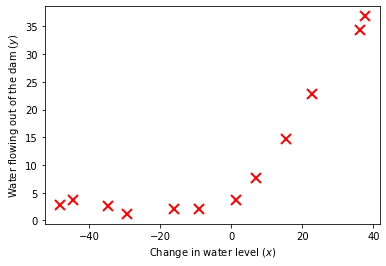

In [2]:
# Load from ex5data1.mat
data = loadmat('ex5data1.mat')

X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Number of examples
m = y.size

# Plot training data
plt.plot(X, y, 'rx', ms=10, mew=2)
plt.xlabel(r'Change in water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)');

In the following parts, you will implement linear regression and use that to fit
a straight line to the data and plot learning curves. Following that, you will
implement polynomial regression to find a better fit to the data.
### 1.2 Regularized linear regression cost function
Recall that regularized linear regression has the following cost function:

\begin{equation}
J(\theta) = \frac{1}{2m}\left( \sum_{i=1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)^2 \right)
+ \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)
\end{equation}

where $\lambda$ is a regularization parameter which controls the degree of regularization
(thus, help preventing overfitting). The regularization term puts a penalty on the
overall cost $J$. As the magnitudes of the model parameters $\theta_j$ increase,
the penalty increases as well. Note that you should not regularize the $\theta_0$
term.

You should now complete the code of function `linearRegCost`, which calculates
the regularized linear regression cost function. If possible, try to vectorize
you code and avoid writing loops.

In [3]:
def linearRegCost(X, y, theta, lam=0.0):
    """
    Compute the cost and gradient for regularized linear regression with
    multiple variables.

    Parameters
    ----------
    X : array_like
        The dataset. A matrix with shape (m, n+1) where m is the total number of
        examples, and n is the number of features before adding the bias term.
    y : array_like
        The functions values at each data point. A vector of shape (m, ).
    theta : array_like
        The parameter for linear regression. A vector of shape (n+1, ).
    lam : float, optional
        The regularization parameter.
    Returns
    -------
    cost : float
        The computed cost function.
    grad : array_like
        The value of the cost function gradient w.r.t theta. A vector of
        shape (n+1, ).
    """
    m = y.size
    h = np.dot(X, theta)

    cost = np.sum(np.square(h - y)) / (2 * m) + \
           lam * np.sum(np.square(theta[1:])) / (2 * m)
    grad = np.dot(h - y, X) / m
    grad[1:] = grad[1:] + lam * theta[1:] / m

    return cost, grad

When you are finished, the next cell will run your cost function using
$\text{theta}$ initialized at $[1;\ 1]$. You should expect to see an output of
$303.993$.

In [4]:
theta = np.array([1, 1])
cost, grad = linearRegCost(np.c_[np.ones([m, 1]), X], y, theta, lam=1)

print('Cost at theta = [1, 1]:   %f' % cost)
print('The value should be about 303.993192')

Cost at theta = [1, 1]:   303.993192
The value should be about 303.993192


### 1.3 Regularized linear regression gradient
Correspondingly, the partial derivative of regularized linear regression's cost
for $\theta_j$ is defined as

\begin{aligned}
  \frac{\partial J(\theta)}{\partial \theta_0} &=
    \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)
    x_j^{(i)} & \text{for } j = 0 \\
  \frac{\partial J(\theta)}{\partial \theta_j} &=
    \frac{1}{m} \sum_{i=1}^m\left( h_{\theta}(x^{(i)}) - y^{(i)} \right)
    x_j^{(i)} + \frac{\lambda}{m}\theta_j & \text{for } j \geq 0
\end{aligned}

In the function `linearRegCost`, add code to calculate the gradient, returning
it in the variable `grad`. You should expected to see a gradient of
$[-15.30;\, 598.250]$.

In [5]:
print('Gradient at theta = [1, 1]: [{:.6f}, {:.6f}]'.format(*grad))
print('This value should be about: [-15.303016; 598.250744]')

Gradient at theta = [1, 1]: [-15.303016, 598.250744]
This value should be about: [-15.303016; 598.250744]


### 1.4 Fitting linear regression
Once your cost function and gradient are working correctly, the next cell will
run the code in function `trainLinearReg` to compute the optimal values of $\theta$.
This training function uses `fmincg` to optimize the cost function.

In [6]:
def trainLinearReg(linearRegCost, X, y, lam=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.

    Parameters
    ----------
    linearRegCost : function
        The function to compute the cost and gradient of regularized linear
        regression.
    X : array_like
        The dataset with shape (m, n + 1). The bias term is assumed to be concatenated.
    y : array_like
        Function values at each datapoint. A vector of shape (m,).
    lam : float, optional
        The regularization parameter.
    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.

    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCost(X, y, t, lam)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='CG', options=options)

    return res.x

In this part, we set regularization parameter $\lambda$ to zero. Because our
current implementation of linear regression is trying to fir a 2-dimensional
$\theta$, regularization will not be incredibly helpful for a $\theta$ of such
low dimension. In the later parts of the exercise, you will be using polynomial
regression with regularization.

Finally, the code in the next cell should also plot the best fit line.

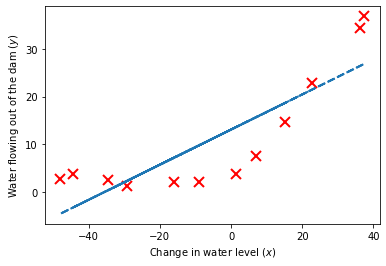

In [7]:
# Add a column of ones for the y-intercept
X_aug = np.c_[np.ones([m, 1]), X]
# Train linear regression with lambda = 0
theta = trainLinearReg(linearRegCost, X_aug, y, lam=0)

# Plot fit over the data
plt.plot(X, y, 'rx', ms=10, mew=2)
plt.xlabel(r'Change in water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)')
plt.plot(X, np.dot(X_aug, theta), '--', lw=2);

The best fit line tells us that the model is not a good fit to the data because
the data has a non-linear pattern. While visualizing the best fit as shown is
one possible way to debug your learning algorithm, it is not always easy to visualize
the data and model. In the next section, you will implement a function to generate
learning curves that can help you debug your learning algorithm even if it is
not easy to visualize the data.

## 2 Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Models
with high bias are not complex enough for the data and tend to underfit, while
models with high variance overfit to the training data.

In the first part of the exercise, you will plot training and test errors on a
learning curve to diagnose bias-variance problems.

### 2.1 Learning curves
You will now implement code to generate the learning curves that will be useful
in debugging learning algorithms. Recall that a learning curve plots training
and cross validation error as a function of training set size. Your job is to
fill in the function `learningCurve` so that it returns a vector of errors for
the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error
for different *training* set sizes. To obtain different training set sizes,
you should use different subsets of the original training set $X$.
Specifically, for a training set size of $i$, you should use the first $i$
examples (i.e., $X(1:i,\,:)$) and $y(1:i)$).

You can use the `trainLinearReg` function to find the $\theta$ parameters.
Note that the $\text{lambda}$ is passed as a parameter to the `learningCurve`
function. After learning the $\theta$ parameters, you should compute the **error**
on the training and cross validation sets. Recall that the training error for
a dataset is defined as

\begin{equation}
J_{\text{train}}(\theta)=\frac{1}{2m}
\left[ \sum_{i=1}^m \left( h_{\theta}(x^{(i}) - y^{(i)}\right)^2 \right].
\end{equation}

In particular, note that the training error does not include the regularization
term. One way to compute the training error is to use your existing cost function
and set $\lambda$ to 0 *only* when using it to compute the training set error
and cross validation error. When you are computing the training set error,
make sure you compute it on the training subset (i.e., $X(1:n,\, :)$ and
$y(1:n)$) (instead of the entire training set). However, for the cross
validation error, you should compute it over the *entire* cross validation
set. You should store the computed errors in the vectors $\text{error_train}$
and $\text{error_val}$.

In [8]:
def learningCurve(X, y, Xval, yval, lam=0):
    """
    Generates the train and cross validation set errors needed to plot a
    learning curve.
    In this function, you will compute the train and test errors for dataset
    sizes from 1 up to m. In practice, when working with larger datasets,
    you might want to do this in larger intervals.

    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m, n + 1) where m is the
        total number of examples, and n is the number of features before
        adding the bias term.
    y : array_like
        The functions values at each training datapoint. A vector of shape
        (m, ).
    Xval : array_like
        The validation dataset. Matrix with shape (m_val, n + 1).
    yval : array_like
        The functions values at each validation datapoint. A vector of shape
        (m_val, ).
    lam : float, optional
        The regularization parameter.

    Returns
    -------
    error_train : array_like
        A vector of shape (m, ). error_train[i] contains the training error
        for i examples.
    error_val : array_like
        A vector of shape (m, ). error_val[i] contains the validation error
        for i training examples.

    Instructions
    ------------
    Fill in this function to return training errors in error_train and the cross
    validation errors in error_val. i.e., error_train[i] and error_val[i] should
    give you the errors obtained after training on i examples.
    """
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    for i in range(1, m + 1):
        theta_t = trainLinearReg(linearRegCost, X[:i], y[:i], lam=lam)
        error_train[i - 1], _ = linearRegCost(X[:i], y[:i], theta_t, lam=0)
        error_val[i - 1], _   = linearRegCost(Xval, yval, theta_t, lam=0)

    return error_train, error_val

When you are finished, the next cell will print the learning curves and produce
a plot.

# Training Exampels	Train Error	Cross Validation Error
	1		0.000000	205.121096
	2		0.000000	110.300366
	3		3.286595	45.010232
	4		2.842678	48.368911
	5		13.154049	35.865141
	6		19.443963	33.829957
	7		20.098522	31.970987
	8		18.172859	30.862446
	9		22.609405	31.135998
	10		23.261462	28.936207
	11		24.317250	29.551432
	12		22.373906	29.433818


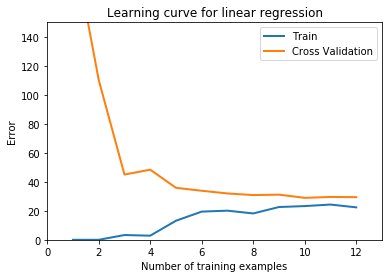

In [9]:
X_aug = np.c_[np.ones([m, 1]), X]
Xval_aug = np.c_[np.ones([yval.size, 1]), Xval]
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lam=0)

plt.plot(np.arange(1, m + 1), error_train, np.arange(1, m + 1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

print('# Training Exampels\tTrain Error\tCross Validation Error')
for i in range(m):
    print('\t%d\t\t%f\t%f' % (i + 1, error_train[i], error_val[i]))

## 3 Polynomial regression
The problem with our linear model was that it was too simple for the data and
resulted in underfitting (high bias). In this part of the exercise, you will
address this problem by adding more features.

For use polynomial regression, our hypothesis has the form:

\begin{align}
h_{\theta}(x) &= \theta_0 + \theta_1 * (\text{waterLevel}) + \theta_2 *
(\text{waterLevel})^2 + \cdots + \theta_p * (\text{waterLevel})^p \\
&= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}

Notice that by defining $x_1 = \text{waterLevel}$, $x_2 = (\text{waterLevel})^2$,
..., $x_p = (\text{waterLevel})^p$, we obtain a linear regression model where
the features are the various powers of the original value $\text{waterLevel}$.

Now, you will add more features using the higher powers of the existing feature
$x$ in the dataset. Your task in this part is to complete the code in the function
`polyFeatures` so that the function maps the original training set $X$ of size
$m \times 1$ into its higher powers. Specifically, when a training set $X$ of size
$ m \times 1$ is passed into the function, the function should return a $m \times p$
matrix $\text{X_poly}$, where column 1 holds the original values of $X$, column
2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on.
Note that you don't have to account for the zero-eth power in this function.

In [10]:
def polyFeatures(X, p):
    """
    Maps X (1-D vector) into the p-th power

    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    p : int
        The polynomial power to map the features.

    Returns
    -------
    X_poly : array_like
        A matrix of shape (m, p) where p is the polynomial power and m is
        the number of examples. That is:
        X_poly[i, :] = [X[i], X[i]**2, ..., X[i]**p]
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros([X.shape[0], p])
    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)
    return X_poly

Now you have a function that will map features to a higher dimension. Before
learning the parameters $\theta$ for the polynomial regression, we first call
`featureNormalize` and normalize the features of the training set, storing the
$\text{mu}$, $\text{sigma}$ parameters separately.

In [11]:
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the
    mean value of each feature is 0 and the standard deviation is 1. This is
    often a good pre-processing step to do when working with learning algorithms.

    Parameters
    ----------
    X : array_like:
        An dataset which is a (m, n) matrix, where m is the number of examples,
        and n is the number of dimension for each example

    Returns
    -------
    X_norm : array_like
        The normalized input dataset.

    mu : array_like
        A vector of size n corresponding to the mean for each dimension across
        all examples.

    sigma : array_like
        A vector of size n corresponding to the standard deviations for each
        dimension across all examples.
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma

    return X_norm, mu, sigma

The next cell will apply it to the training set, the test set, and the cross
validation set.

In [12]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)    # Normalize
X_poly = np.c_[np.ones([m, 1]), X_poly]         # Add ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.c_[np.ones([ytest.size, 1]), X_poly_test]

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.c_[np.ones([yval.size, 1]), X_poly_val]

print('Normalized Training Example 1:')
print(X_poly[0, :])

Normalized Training Example 1:
[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


### 3.1 Learning Polynomial Regression
After you have completed the function `polyFeatures`, we will proceed to train
polynomial regression using your linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector,
we are still solving a linear regression optimization problem. The polynomial
terms have simply turned into features that we can use for linear regression.
We are using the same cost function and gradient that you wrote for the earlier
part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It
turns out that if we run the training directly on the projected data, will not
work well as the features would be badly scaled (e.g., an example with $x = 40$
will now have a feature $x_8 = 40^8 = 6.5\times 10^{12}$. Therefore, you will
need to use feature normalization.

After learning the parameters $\theta$, you should see two plots generated for
polynomial regression with $\lambda = 0$.

In [13]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.

    Parameters
    ----------
    polyFeatures : func
        A function which generates polynomial features from a single feature.
    min_x : float
        The minimum value for the feature.
    max_x : float
        The maximum value for the feature.
    mu : float
        The mean feature value over the training dataset.
    sigma : float
        The feature standard deviation of the training dataset.
    theta : array_like
        The parameters for the trained polynomial linear regression.
    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger that the min and max values to get an
    # idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 10, max_x + 20, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.c_[np.ones([x.shape[0], 1]), X_poly]

    # Plot
    plt.plot(x, np.dot(X_poly, theta), '--', lw=2)

Polynomial Regression ($\lambda$ = 0.000000
# Training Exampels	Train Error	Cross Validation Error
	1		0.000000	160.721900
	2		0.000000	160.121510
	3		0.000000	61.755005
	4		0.000000	61.928895
	5		0.000000	6.597864
	6		0.000000	10.639122
	7		0.000003	28.240663
	8		0.005434	17.855417
	9		0.055845	12.064460
	10		0.038123	25.581916
	11		0.087819	6.793333
	12		0.040961	22.081980


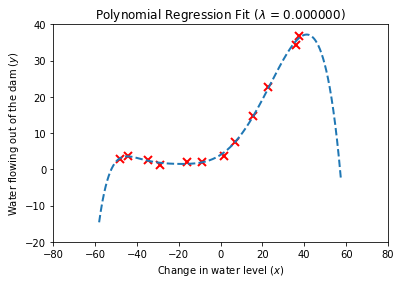

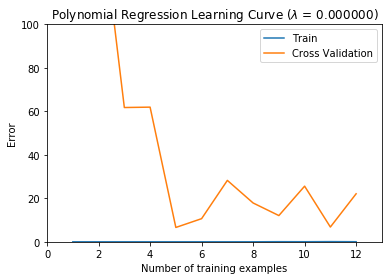

In [14]:
lam = 0
theta = trainLinearReg(linearRegCost, X_poly, y, lam=lam, maxiter=143)

# Plot training data and fit
plt.plot(X, y, 'rx', ms=8, mew=2)

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)
plt.title(r'Polynomial Regression Fit ($\lambda$ = %f)' % lam)
plt.xlabel(r'Change in water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)')
plt.axis([-80, 80, -20, 40])

plt.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lam)
plt.plot(np.arange(1, 1 + m), error_train, np.arange(1, 1 + m), error_val)
plt.title(r'Polynomial Regression Learning Curve ($\lambda$ = %f)' % lam)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend(['Train', 'Cross Validation'])

print(r'Polynomial Regression ($\lambda$ = %f' % lam)
print('# Training Exampels\tTrain Error\tCross Validation Error')
for i in range(m):
    print('\t%d\t\t%f\t%f' % (i + 1, error_train[i], error_val[i]))

One way to combat the overfitting (high-variance) problem is to add
regularization to the model. In the next section, you will get to try different
$\lambda$ parameters to see how regularization can lead to a better model.

### 3.2 Adjusting the regularization parameter
In this section, you will get to observe how the regularization parameter affects
the bias-variance of regularized polynomial regression. You should now modify
the $\text{lambda}$ parameter and try $\lambda = 1,100$. For each of these values,
the script should generate a polynomial fit to the data and also a learning
curve.

For $\lambda = 1$, you should see a polynomial fit that follows the data trend
well and a learning curve showing that both the cross validation and training
error converge to a relatively low value. This shows the $\lambda = 1$ regularized
polynomial regression model does not have the high-bias or high-variance problems.
In effect, it achieves a good trade-off between bias and variance.

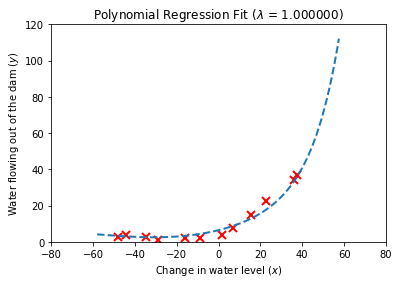

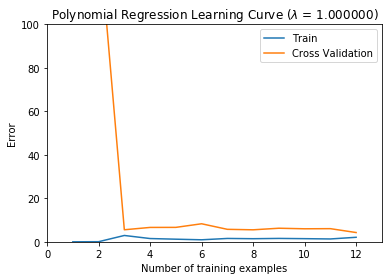

In [15]:
lam = 1
theta = trainLinearReg(linearRegCost, X_poly, y, lam=lam, maxiter=100)

# Plot training data and fit
plt.plot(X, y, 'rx', ms=8, mew=2)

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)
plt.title(r'Polynomial Regression Fit ($\lambda$ = %f)' % lam)
plt.xlabel(r'Change in water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)')
plt.axis([-80, 80, 0, 120])

plt.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lam)
plt.plot(np.arange(1, 1 + m), error_train, np.arange(1, 1 + m), error_val)
plt.title(r'Polynomial Regression Learning Curve ($\lambda$ = %f)' % lam)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend(['Train', 'Cross Validation']);

For $\lambda = 100$, you should see a polynomial fit that does not follow the
data well. In this case, there is too much regularization and the model is
unable to fit the training data.

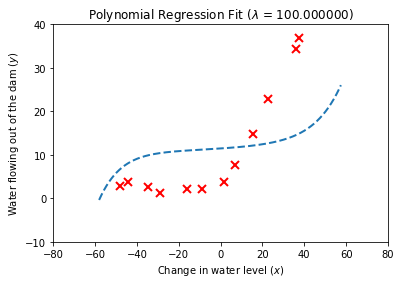

In [16]:
lam = 100
theta = trainLinearReg(linearRegCost, X_poly, y, lam=lam, maxiter=200)

# Plot training data and fit
plt.plot(X, y, 'rx', ms=8, mew=2)

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)
plt.title(r'Polynomial Regression Fit ($\lambda$ = %f)' % lam)
plt.xlabel(r'Change in water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)')
plt.axis([-80, 80, -10, 40]);

### 3.3 Selecting $\lambda$ using a cross validation
From the previous parts of the exercise, you observed that the value of $\lambda$
can significantly affect the results of regularized polynomial regression on the
training and cross validation set. In particular, a model without regularization
($\lambda = 0$) fits the training set well, but does not generalize. Conversely,
a model with too much regularization ($\lambda = 100$) does not fit the training
set and testing set well. A good choice of $\lambda$ (e.g. $\lambda = 1$) can
provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$
parameter. Concretely, you will use a cross validation set to evaluate how good
each $\lambda$ value is. After selecting the best $\lambda$ value using the cross
validation set, we can then evaluate the model on the test set to estimate
how well the method will perform on actual unseen data.

Your task is to complete the code in the function `validationCurve`.
Specifically, you should use the `trainLinearReg` function to train the model
using different values of $\lambda$ and compute the training error and cross
validation error. You should try $\lambda$ in the following range:
$\{0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10 \}$.

In [17]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda.

    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m, n) where m is the
        total number of training examples, and n is the number of features
        including any polynomial features.
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    Xval : array_like
        The validation dataset. Matrix with shape (m_val, n) where m_val is the
        total number of validation examples, and n is the number of features
        including any polynomial features.
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).

    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in
        cross validation.
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    """
    # Selected values of lambda
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        l = lambda_vec[i]
        theta_t = trainLinearReg(linearRegCost, X, y, lam=l)
        error_train[i], _ = linearRegCost(X, y, theta_t, lam=0)
        error_val[i], _ = linearRegCost(Xval, yval, theta_t, lam=0)

    return lambda_vec, error_train, error_val

After you have completed the code, the next cell will run your function and
plot a cross validation curve of error v.s. $\lambda$ that allows you select
which $\lambda$ parameter to use.

lambda		Train Error	Validation Error
0.000000	0.040961	22.081980
0.001000	0.112761	9.881604
0.003000	0.172953	16.697436
0.010000	0.221503	16.945323
0.030000	0.281866	12.830957
0.100000	0.459308	7.587252
0.300000	0.921774	4.636807
1.000000	2.076182	4.260623
3.000000	4.901348	3.822899
10.000000	16.092210	9.945504


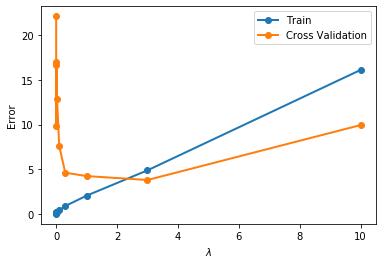

In [18]:
''' Part 8: Validation for Selecting Lambda '''
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print('%f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

In this figure, we can see that the best value of $\lambda$ is around 3. Due
to randomness in the training and validation splits of the dataset, the cross
validation error can sometimes be lower that the training error.

### 3.4 Computing test set error
In the previous part of the exercise, you implement code to compute the cross
validation error for various values of the regularization parameter $\lambda$.
However, to get a better indication of the model's performance in the real
world, it is important to evaluate the "final" model on a test set that was
not used in any part of training (that is, it was neither used to select the
$\lambda$ parameters, nor to learn the model parameters $\theta$). In this section,
you should compute the test error using the best value of $\lambda$ you found.
In our cross validation, we obtained a test error of 3.8599 for $\lambda = 3$.

In [36]:
theta = trainLinearReg(linearRegCost, X_poly, y, lam=3, maxiter=500)
error_test, _ = linearRegCost(X_poly_test, ytest, theta, lam=0)
print('When lambda = 3, the test error is %f' % error_test)

When lambda = 3, the test error is 3.859888
